In [1]:
import glob
import os
import pickle
from scipy.stats import bernoulli

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import rc
from xgboost import XGBRegressor

import xgboost as xgb
import scikitplot as skplt
import scipy.stats as st

# from google.colab import drive
# # mount google drive information in a google colaboratory directory
# drive.mount('/content/gdrive')

# path = r'gdrive/My Drive/Trabajos DS/Data/' # path
path = 'home\Documents\Personal\MIMYANALYTICS\TESIS\TESIS\datasets' #C:\Users\dlongas

In [2]:
#Funciones Útiles
def plot_roc(label, pred):
    """
    Grafica curva ROC
    """
    fpr, tpr, thresholds = roc_curve(label, pred)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, label="AUC %.4f" % roc_auc_score(label, pred))
    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend(loc="lower right")
    # show the plot
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
    
def gap_metricas(prior_mujer, y_proba, y_test, gap = .09):
        
    threshold_m = prior_mujer + gap
    threshold_h = prior_mujer - gap

    prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
    recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
    f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

    prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
    recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
    f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )

    print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
    print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
    print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m)) 
    
    
def precision_recall_curve_hombre(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(y_test,y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 1)')
    plt.plot(thresholds, recall, label = 'recall (label = 1)')   
    plt.xlabel('thresholds (score= prob hombre)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_recall_curve_mujer(y_test,y_proba):
    precision, recall, thresholds = precision_recall_curve(1 - y_test, 1- y_proba)
    precision = precision[:-1]
    recall = recall[:-1]
    plt.plot(thresholds, precision, label = 'precision (label = 0)')
    plt.plot(thresholds, recall, label = 'recall (label = 0)')   
    plt.xlabel('thresholds (score= prob mujer)')
    plt.legend(loc="lower left")
    plt.show()
    
    
def precision_metricas(prior_mujer, y_proba, y_test, prec_esperada = .80, hombre_eval=1):
    
    for gap in list(np.linspace(0, 0.5, 100)):
        threshold_m = prior_mujer + gap
        threshold_h = prior_mujer - gap
        if((threshold_m > 1)|(threshold_h<0)):
            print('No se pudo encontrar datos con ese nivel de precisión.')
            break
        else:
            prec_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_proba > threshold_m).sum()
            recall_m = ((y_proba > threshold_m) & (y_test==1)).sum() * 1. / (y_test==1).sum()
            f1_m = prec_m * recall_m * 2 / (prec_m + recall_m )

            prec_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_proba < threshold_h).sum()
            recall_h = ((y_proba < threshold_h ) & (y_test==0)).sum() * 1. / (y_test == 0).sum()
            f1_h = prec_h * recall_h * 2 / (prec_h + recall_h )
            
            if(((hombre_eval==1)&(prec_h>=prec_esperada))|((hombre_eval==0)&(prec_m>=prec_esperada))):
               print("Porcentaje del total: "+str(round(100*len(y_proba[(y_proba>threshold_m) | (y_proba<threshold_h)])/len(y_proba),2)))
               print("Hombres: precision = %.4f - recall = %.4f - f1 = %.4f " % (prec_h, recall_h, f1_h))
               print("Mujeres: precision = %.4f - recall = %.4f - f1 = %.4f "% (prec_m, recall_m, f1_m))
               break
    if (gap==0.5):
        print('No se pudo encontrar datos con ese nivel de precisión.')

        
def precision_top(y_proba, y_test, top=1000):    
    ref=list(y_proba)
    ref.sort()

    prec_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_proba>=ref[(-1*top)]).sum()
    recall_m = ((y_proba>=ref[(-1*top)]) & (y_test==1)).sum() * 1. / (y_test==1).sum()

    prec_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_proba<=ref[top]).sum()
    recall_h = ((y_proba<=ref[top]) & (y_test==0)).sum() * 1. / (y_test==0).sum()

    print("Porcentaje del total: "+str(round(100*((len(y_proba[y_proba<=ref[top]])+
                                                   len(y_proba[y_proba>=ref[(-1*top)]]))/len(y_proba)),2)))
    print("Hombres: precision = %.4f - recall = %.4f " % (prec_h, recall_h))
    print("Mujeres: precision = %.4f - recall = %.4f "% (prec_m, recall_m))
    

In [3]:
#Descargo dataset final user agent con feature engeneering
df1 = pd.read_csv('df_final_ua_age.csv')
df1 = df1.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df1.shape)
df1.head()

Dataset Size (88807, 64)


,age,Is_pc,Is_mobile,Is_tablet,OS_Android,OS_Linux,OS_Mac OS X,OS_Windows,OS_iOS,navegador_Brand_browser,...,marca_Apple,marca_Huawei,marca_LG,marca_Motorola,marca_Samsung,marca_XiaoMi,Antiguedad_ancient,Antiguedad_new,Antiguedad_old,device_idx
0,2.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
1,3.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2.0
2,1.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.0
3,2.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4.0
4,2.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,5.0


In [4]:
#Descargo dataset final dominios con feature engeneering
df2 = pd.read_csv('df_final_domains_age.csv')
df2 = df2.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df2.shape)
df2.head()

Dataset Size (99469, 18)


,age,domain_type_Alimentos,domain_type_Automovil,domain_type_Busqueda_Laboral,domain_type_Consumo,domain_type_Deportes,domain_type_Educacion,domain_type_Entretenimiento,domain_type_Familia_y_Hogar,domain_type_Farandula,domain_type_Inmobiliaria,domain_type_Linea_Movil,domain_type_Noticias,domain_type_Otros,domain_type_Salud,domain_type_Tramites_Bancarios,domain_type_Viajes,device_idx
0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0
1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
4,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0


In [5]:
#Descargo dataset final dominios con feature engeneering
df3 = pd.read_csv('df_final_urls_age.csv')
df3 = df3.drop(['Unnamed: 0'], axis=1) #,'feature_type'
print('Dataset Size',df3.shape)
df3.head()

Dataset Size (98491, 63)


,device_idx,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,...,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop,age
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2


In [6]:
#Uno por device id a ambos
df = pd.merge(df1, df2, how='inner', on='device_idx')
df = df.rename(columns={'age_x':'age'})
df = df.drop('age_y', axis=1)
print(df.shape)
df= df.drop_duplicates()
print(df.shape)
print(df.columns)

df = pd.merge(df, df3, how='inner', on='device_idx')
df = df.rename(columns={'age_x':'age'})
df = df.drop('age_y', axis=1)
print(df.shape)
df= df.drop_duplicates()
print(df.shape)
print(df.columns)
pd.options.display.max_columns = None #veo todas las columnas
df.head()

(88583, 80)
(88583, 80)
Index(['age', 'Is_pc', 'Is_mobile', 'Is_tablet', 'OS_Android', 'OS_Linux',
       'OS_Mac OS X', 'OS_Windows', 'OS_iOS', 'navegador_Brand_browser',
       'navegador_Chrome', 'navegador_Edge', 'navegador_Firefox',
       'navegador_Safari', 'navegador_SocialApp', 'modelo_Moto G (5',
       'modelo_Moto G (5S', 'modelo_Samsung SM-A015M',
       'modelo_Samsung SM-A105M', 'modelo_Samsung SM-A107M',
       'modelo_Samsung SM-A205G', 'modelo_Samsung SM-A207M',
       'modelo_Samsung SM-A217M', 'modelo_Samsung SM-A305G',
       'modelo_Samsung SM-A307G', 'modelo_Samsung SM-A315G',
       'modelo_Samsung SM-A505G', 'modelo_Samsung SM-A515F',
       'modelo_Samsung SM-G532M', 'modelo_Samsung SM-G570M',
       'modelo_Samsung SM-G610M', 'modelo_Samsung SM-G950F',
       'modelo_Samsung SM-J260M', 'modelo_Samsung SM-J400M',
       'modelo_Samsung SM-J415G', 'modelo_Samsung SM-J600G',
       'modelo_Samsung SM-J610G', 'modelo_Samsung SM-J700M',
       'modelo_Samsung SM-J

,age,Is_pc,Is_mobile,Is_tablet,OS_Android,OS_Linux,OS_Mac OS X,OS_Windows,OS_iOS,navegador_Brand_browser,navegador_Chrome,navegador_Edge,navegador_Firefox,navegador_Safari,navegador_SocialApp,modelo_Moto G (5,modelo_Moto G (5S,modelo_Samsung SM-A015M,modelo_Samsung SM-A105M,modelo_Samsung SM-A107M,modelo_Samsung SM-A205G,modelo_Samsung SM-A207M,modelo_Samsung SM-A217M,modelo_Samsung SM-A305G,modelo_Samsung SM-A307G,modelo_Samsung SM-A315G,modelo_Samsung SM-A505G,modelo_Samsung SM-A515F,modelo_Samsung SM-G532M,modelo_Samsung SM-G570M,modelo_Samsung SM-G610M,modelo_Samsung SM-G950F,modelo_Samsung SM-J260M,modelo_Samsung SM-J400M,modelo_Samsung SM-J415G,modelo_Samsung SM-J600G,modelo_Samsung SM-J610G,modelo_Samsung SM-J700M,modelo_Samsung SM-J701M,modelo_Samsung SM-J710MN,modelo_XiaoMi Redmi Note 7,modelo_XiaoMi Redmi Note 8,modelo_iPhone,modelo_moto e5,modelo_moto e5 play,modelo_wv,VOS_Android 10,VOS_Android 6,VOS_Android 7,VOS_Android 8,VOS_Android 9,VOS_Windows 10,VOS_Windows 7,VOS_Windows 8,marca_Apple,marca_Huawei,marca_LG,marca_Motorola,marca_Samsung,marca_XiaoMi,Antiguedad_ancient,Antiguedad_new,Antiguedad_old,device_idx,domain_type_Alimentos,domain_type_Automovil,domain_type_Busqueda_Laboral,domain_type_Consumo,domain_type_Deportes,domain_type_Educacion,domain_type_Entretenimiento,domain_type_Familia_y_Hogar,domain_type_Farandula,domain_type_Inmobiliaria,domain_type_Linea_Movil,domain_type_Noticias,domain_type_Otros,domain_type_Salud,domain_type_Tramites_Bancarios,domain_type_Viajes,0221,21,Otros,almundo,ambito,animeflv,ausa,autocosmos,buenosaires,bumeran,contextotucuman,coppel,credicuotas,credisense,creditosparatodos,cronista,curriculumvitaeempresarial,depor,diarioregistrado,disco,elbocon,elcomercio,eldia,empleosit,futbollibre,gardenlife,gba,infotechnology,itau,jetsmart,jumbo,lacapitalmdp,laserenisimavaatucasa,losandes,minutouno,movistar,mundoazulgrana,nissan,perfil,philips,planrombo,prestamosparatodos,pronto,ratingcero,renault,rojadirectatv,sancorsalud,solodeportes,sommiercenter,starbucksrewards,supermercadosdia,swarovski,televisionlibre,toyota,tuenti,veadigital,veraz,vicentelopez,ypf,zonajobs,zonaprop
0,2.0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0

In [8]:
print('Clases')
print(df['age'].value_counts())

Clases
2.0    26787
3.0    25788
4.0    15172
5.0     9410
6.0     5689
1.0     5038
Name: age, dtype: int64


In [9]:
variables_dep = []
for col in df.columns:
    if col != 'age': 
        if col != 'device_idx':
            variables_dep.append(col)        
variables_dep

['Is_pc',
 'Is_mobile',
 'Is_tablet',
 'OS_Android',
 'OS_Linux',
 'OS_Mac OS X',
 'OS_Windows',
 'OS_iOS',
 'navegador_Brand_browser',
 'navegador_Chrome',
 'navegador_Edge',
 'navegador_Firefox',
 'navegador_Safari',
 'navegador_SocialApp',
 'modelo_Moto G (5',
 'modelo_Moto G (5S',
 'modelo_Samsung SM-A015M',
 'modelo_Samsung SM-A105M',
 'modelo_Samsung SM-A107M',
 'modelo_Samsung SM-A205G',
 'modelo_Samsung SM-A207M',
 'modelo_Samsung SM-A217M',
 'modelo_Samsung SM-A305G',
 'modelo_Samsung SM-A307G',
 'modelo_Samsung SM-A315G',
 'modelo_Samsung SM-A505G',
 'modelo_Samsung SM-A515F',
 'modelo_Samsung SM-G532M',
 'modelo_Samsung SM-G570M',
 'modelo_Samsung SM-G610M',
 'modelo_Samsung SM-G950F',
 'modelo_Samsung SM-J260M',
 'modelo_Samsung SM-J400M',
 'modelo_Samsung SM-J415G',
 'modelo_Samsung SM-J600G',
 'modelo_Samsung SM-J610G',
 'modelo_Samsung SM-J700M',
 'modelo_Samsung SM-J701M',
 'modelo_Samsung SM-J710MN',
 'modelo_XiaoMi Redmi Note 7',
 'modelo_XiaoMi Redmi Note 8',
 'model

**Number of DEVICES by target variable**

In [12]:
tmp = df.groupby(['age']).nunique()[['device_idx']]
tmp['porc'] = df['age'].value_counts(normalize=True) * 100
tmp['AgeRange'] = np.where(tmp.index==1, '18-24',
                           np.where(tmp.index==2, '25-34',
                                    np.where(tmp.index==3, '35-44',
                                             np.where(tmp.index==4, '45-54',
                                                      np.where(tmp.index==5, '55-64','65+')))))
tmp.rename(columns={'device_idx':'# Devices',
                    'porc':'% Devices'})

,# Devices,% Devices,AgeRange
age,,,
1.0,5027,5.732557,18-24
2.0,26724,30.479951,25-34
3.0,25710,29.343225,35-44
4.0,15139,17.263666,45-54
5.0,9386,10.707296,55-64
6.0,5681,6.473306,65+


**Variance Inflation Factor**

In [13]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set (solo numericas, por eso hago acá la transformacion a dummies)
X = df[variables_dep]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

pd.options.display.max_rows = None
vif_data.sort_values('VIF',ascending=False)

C:\Users\dlongas\AppData\Roaming\Python\Python37\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
53,marca_Apple,inf
5,OS_Mac OS X,inf
7,OS_iOS,inf
60,Antiguedad_new,2320.022005
6,OS_Windows,2045.445441
61,Antiguedad_old,1186.948468
3,OS_Android,1032.184906
50,VOS_Windows 10,437.619795
0,Is_pc,436.327724
1,Is_mobile,401.473004


In [18]:
# defino X e y
# get the dependent and the independents variables
X=df[variables_dep]
y = df['age']

- Train: subconjunto para entrenar el modelo.
- Test: subconjunto para verificar que el modelo reproduce los resultados deseados.

In [19]:
# get train and test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0,test_size =0.2)

In [20]:
Xtrain.shape

(70307, 119)

Debido a problemas de escalas diferentes en distintas variables se suele estandarizar los datos, es decir restarle la media y dividir sobre la varianza.

In [21]:
#data standarization
scaler = StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.transform(Xtest)

**MODELOS**

**XG Boost**

In [24]:
model_xgb = xgb.XGBClassifier(n_jobs=-1)

one_to_left = st.beta(10, 1) #  This distribution will return values between 0 and 1, nearer to 1 #WARNING, NO TENGO CLASES DESB

max_depth = list(range(3,12))
max_depth.append(None)

hyperparameters = {  
    "n_estimators": st.randint(50,200), # Number of boosted trees to fit.
    "max_depth": max_depth,     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

xgb_best_model = RandomizedSearchCV(estimator = model_xgb, 
                            param_distributions = hyperparameters,
                            n_iter = 50, cv = 3, verbose=4, 
                            random_state=42, n_jobs = -1)
xgb_best_model.fit(Xtrain, ytrain)

ypred = xgb_best_model.predict(Xtest) 
yproba = xgb_best_model.predict_proba(Xtest)[:,1]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 100.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 161.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
best_params=xgb_best_model.best_params_
best_params

{'colsample_bytree': 0.7924381566806008,
 'gamma': 3.307503046705137,
 'learning_rate': 0.271105986734196,
 'max_depth': 5,
 'min_child_weight': 20.606631674320912,
 'n_estimators': 165,
 'reg_alpha': 2.994488920695857,
 'subsample': 0.819057346478571}

Se utilizarán los mejores parámetros encontrados.

In [26]:
xgboost = xgb.XGBClassifier(objective= 'multi:softprob',
                            n_jobs=-1,
                            colsample_bytree = best_params['colsample_bytree'],
                            gamma= best_params['gamma'],
                            learning_rate= best_params['learning_rate'],
                            max_depth = best_params['max_depth'],
                            min_child_weight= best_params['min_child_weight'],
                            n_estimators= best_params['n_estimators'],
                            reg_alpha= best_params['reg_alpha'],
                            subsample= best_params['subsample'])

xgboost.fit(Xtrain, ytrain, eval_metric="auc", verbose=False)


ypred = xgboost.predict(Xtest)
yproba = xgboost.predict_proba(Xtest)[:,1]

In [29]:
for i, class_ in enumerate(xgboost.classes_):
    print(class_, np.round(roc_auc_score(ytest == class_, yproba), 3))

1.0 0.67
2.0 0.64
3.0 0.49
4.0 0.41
5.0 0.37
6.0 0.307


In [49]:
for i, class_ in enumerate(xgboost.classes_):
    print(class_, np.round(roc_auc_score(ytest == class_, ypred), 3))

1.0 0.371
2.0 0.393
3.0 0.513
4.0 0.563
5.0 0.596
6.0 0.646


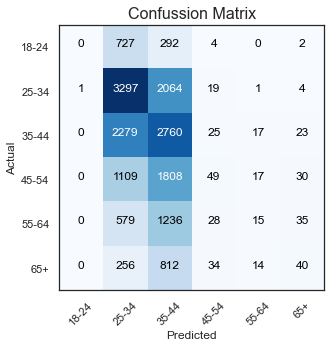

In [31]:
sns.set(style="white")
# confussion matrix
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)

# chart
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['18-24','25-34','35-44','45-54','55-64','65+'], #classes=['No','Yes']
                      title='Confussion Matrix')

# tn, fp, fn, tp = cnf_matrix.ravel()
# # measures :
# tn, fp, fn, tp = cnf_matrix.ravel()
# acc = round((tp + tn) / (tp + tn + fn + fp),3)
# rec = round(tp / (tp + fn),3)
# tnr = round(tn / (fp + tn),3)
# pre = round(tp/(tp + fp), 3)
# print("Accuracy  : ", acc)
# print("Recall  : ", rec)
# print("Log Loss: ",round(metrics.log_loss(ytest,yproba),3))
# print("Precision  : ", pre)

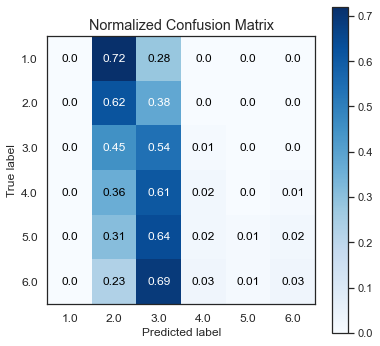

In [48]:
#predictions = cross_val_predict(xgboost, X, y)
plt.rcParams["figure.figsize"] = (6,6)
skplt.metrics.plot_confusion_matrix(y, predictions, normalize=True)
plt.show()

In [34]:
predictions_proba = cross_val_predict(xgboost, Xtrain, ytrain,method='predict_proba')
predictions_proba

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:48:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:49:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:51:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

array([[0.04, 0.22, 0.29, 0.21, 0.15, 0.09],
       [0.03, 0.13, 0.3 , 0.24, 0.16, 0.14],
       [0.04, 0.27, 0.34, 0.19, 0.1 , 0.05],
       ...,
       [0.04, 0.27, 0.29, 0.2 , 0.13, 0.07],
       [0.02, 0.1 , 0.25, 0.21, 0.17, 0.25],
       [0.1 , 0.39, 0.29, 0.12, 0.07, 0.03]], dtype=float32)

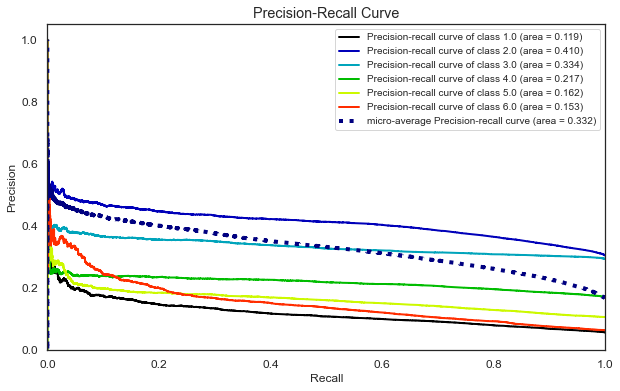

In [39]:
plt.rcParams["figure.figsize"] = (10,6)
skplt.metrics.plot_precision_recall(ytrain, predictions_proba)
plt.legend(loc=0,prop={'size':10})
# detalles de cómo cambiar la leyenda en matplotlib https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

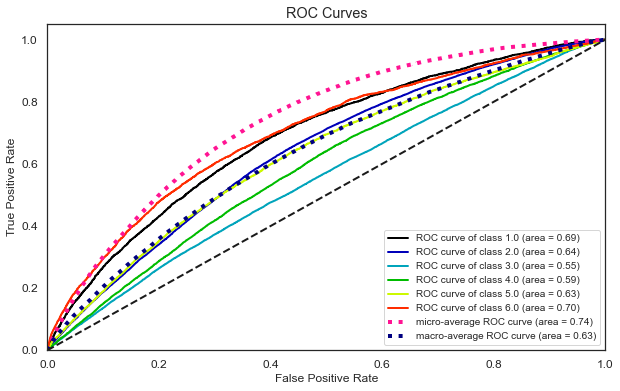

In [50]:
plt.rcParams["figure.figsize"] = (10,6)
skplt.metrics.plot_roc(ytrain, predictions_proba)
plt.legend(fontsize=10, loc='lower right')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:16:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:17:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

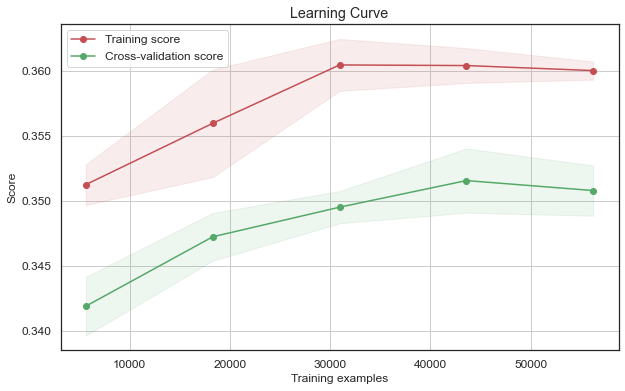

In [46]:
skplt.estimators.plot_learning_curve(xgboost, Xtrain, ytrain)
plt.show()

In [44]:
features = X.columns.tolist()#eature_index.feature.tolist() + ga_columns

df_importance = pd.DataFrame({"importance": xgboost.feature_importances_,
                              "feature": features
                             }).sort_values("importance", ascending=False)
df_importance

,importance,feature
66,0.046957,bumeran
76,0.045444,disco
43,0.041880,domain_type_Busqueda_Laboral
55,0.031787,domain_type_Tramites_Bancarios
116,0.031281,zonajobs
65,0.021937,buenosaires
95,0.020919,perfil
98,0.020351,prestamosparatodos
112,0.016510,veadigital
62,0.014826,animeflv


In [45]:
df_importance.head(20)

,importance,feature
66,0.046957,bumeran
76,0.045444,disco
43,0.041880,domain_type_Busqueda_Laboral
55,0.031787,domain_type_Tramites_Bancarios
116,0.031281,zonajobs
65,0.021937,buenosaires
95,0.020919,perfil
98,0.020351,prestamosparatodos
112,0.016510,veadigital
62,0.014826,animeflv
